# Here is the background information on your task
For this part of the project we will be examining the performance in trial vs control stores to provide a recommendation for each location based on our insight. Below are some of the areas I want you to focus on, of course if you discover any other interesting insights feel free to include them in your findings.

Select control stores – explore the data and define metrics for your control store selection – think about what would make them a control store. Look at the drivers and make sure you visualise these in a graph to better determine if they are suited. For this piece it may even be worth creating a function to help you.

Assessment of the trial – this one should give you some interesting insights into each of the stores, check each trial store individually in comparison with the control store to get a clear view of its overall performance. We want to know if the trial stores were successful or not.

Collate findings – summarise your findings for each store and provide an recommendation that we can share with Julia outlining the impact on sales during the trial period.

# Here is your task
Julia has asked us to evaluate the performance of a store trial which was performed in stores 77, 86 and 88.

We have chosen to complete this task in R, however, you will also find Python to be a useful tool in this piece of analytics. We have also provided an R solution template if you want some assistance in getting through this Task.

To get started, use the QVI_data dataset below or your output from task 1 and consider the monthly sales experience of each store.

This can be broken down by:

total sales revenue
total number of customers
average number of transactions per customer

Create a measure to compare different control stores to each of the trial stores to do this write a function to reduce having to re-do the analysis for each trial store. Consider using Pearson correlations or a metric such as a magnitude distance e.g. 1- (Observed distance – minimum distance)/(Maximum distance – minimum distance) as a measure.

Once you have selected your control stores, compare each trial and control pair during the trial period. You want to test if total sales are significantly different in the trial period and if so, check if the driver of change is more purchasing customers or more purchases per customers etc.

# Load required libraries and datasets

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t

In [ ]:
# Load required libraries and datasets
filePath = '/content/'
data = pd.read_csv(filePath + 'QVI_data.csv')

In [ ]:
# Set themes for plots
sns.set_theme(style="whitegrid")
plt.rcParams.update({'axes.titlesize': 15, 'axes.titleweight': 'bold'})

# Select control stores
The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established
stores that are operational for the entire observation period.
We would want to match trial stores to control stores that are similar to the trial store prior to the trial period
of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer.

Let’s first create the metrics of interest and filter to stores that are present throughout the pre-trial period

In [ ]:
# Calculate these measures over time for each store
# Create a month ID
data['DATE'] = pd.to_datetime(data['DATE'])
data['YEARMONTH'] = data['DATE'].dt.year * 100 + data['DATE'].dt.month

In [ ]:
# Define the measure calculations
measure_over_time = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', pd.Series.nunique),
    nTxnPerCust=('TXN_ID', lambda x: x.nunique() / data.loc[x.index, 'LYLTY_CARD_NBR'].nunique()),
    nChipsPerTxn=('PROD_QTY', lambda x: x.sum() / data.loc[x.index, 'TXN_ID'].nunique()),
    avgPricePerUnit=('TOT_SALES', lambda x: x.sum() / data.loc[x.index, 'PROD_QTY'].sum())
).reset_index().sort_values(by=['STORE_NBR', 'YEARMONTH'])


In [ ]:
# Filter to the pre-trial period and stores with full observation periods
obs_period_count = measure_over_time['STORE_NBR'].value_counts()
full_obs_period = obs_period_count == 12
full_obs_index = obs_period_count.index[full_obs_period].values
full_obs2 = measure_over_time[measure_over_time['STORE_NBR'].isin(full_obs_index)]

pre_trial_measures = full_obs2[full_obs2['YEARMONTH'] < 201902]

Now we need to work out a way of ranking how similar each potential control store is to the trial store. We
can calculate how correlated the performance of each store is to the trial store.
Let’s write a function for this so that we don’t have to calculate this for each trial store and control store pair.

In [ ]:
#  Function to calculate correlation for a measure.
def calculate_correlation(input_df, metric_col, store_comparison):
    store_numbers = input_df['STORE_NBR'].unique()
    results = []
    base = input_df[input_df['STORE_NBR'] == store_comparison][metric_col].values
    for store in store_numbers:
        compare = input_df[input_df['STORE_NBR'] == store][metric_col].values
        if len(base) == len(compare):
            corr = np.corrcoef(base, compare)[0, 1]
            results.append({'Store1': store_comparison, 'Store2': store, 'corr_measure': corr})
    return pd.DataFrame(results)

Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store’s performance and each control store’s performance.
Let’s write a function for this.

In [ ]:
# Function to calculate magnitude distance
def calculate_magnitude_distance(input_df, metric_col, store_comparison):
    store_numbers = input_df['STORE_NBR'].unique()
    results = []
    for store in store_numbers:
        temp = input_df[input_df['STORE_NBR'].isin([store_comparison, store])]
        pivot = temp.pivot(index='YEARMONTH', columns='STORE_NBR', values=metric_col).dropna()
        if store_comparison in pivot.columns and store in pivot.columns:
            measure = abs(pivot[store_comparison] - pivot[store])
            results.extend([{
                'Store1': store_comparison,
                'Store2': store,
                'YEARMONTH': ym,
                'measure': val
            } for ym, val in measure.items()])
    dist_df = pd.DataFrame(results)
    minmax = dist_df.groupby(['Store1', 'YEARMONTH'])['measure'].agg(['min', 'max']).reset_index()
    merged = dist_df.merge(minmax, on=['Store1', 'YEARMONTH'])
    merged['magnitudeMeasure'] = 1 - (merged['measure'] - merged['min']) / (merged['max'] - merged['min'] + 1e-6)
    final = merged.groupby(['Store1', 'Store2'])['magnitudeMeasure'].mean().reset_index()
    final.rename(columns={'magnitudeMeasure': 'mag_measure'}, inplace=True)
    return final

Now let’s use the functions to find the control stores! We’ll select control stores based on how similar
monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will
need to use our functions to get four scores, two for each of total sales and total customers.

## Store 77

In [ ]:
# Applying the functions to calculate control store similarity
trial_store = 77
corr_nSales = calculate_correlation(pre_trial_measures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store)
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store)


We’ll need to combine the all the scores calculated using our function to create a composite score to rank
on.
Let’s take a simple average of the correlation and magnitude scores for each driver. Note that if we consider
it more important for the trend of the drivers to be similar, we can increase the weight of the correlation
score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the
drivers to be more important, we can lower the weight of the correlation score.

In [ ]:
# Combine score
corr_weight = 0.5
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + score_nSales['mag_measure'] * (1 - corr_weight)

score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + score_nCustomers['mag_measure'] * (1 - corr_weight)

Now we have a score for each of total number of sales and number of customers. Let’s combine the two
via a simple average.

In [ ]:
# Final score
score_control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_control['finalControlScore'] = 0.5 * score_control['scoreNSales'] + 0.5 * score_control['scoreNCust']

The store with the highest score is then selected as the control store since it is most similar to the trial store.

In [ ]:
# Get top control store (excluding itself)
control_store = score_control[score_control['Store1'] == trial_store].sort_values('finalControlScore', ascending=False).iloc[1]['Store2']
print(f"Selected control store for trial store {trial_store}: {int(control_store)}")

Selected control store for trial store 77: 233


Now that we have found a control store, let’s check visually if the drivers are indeed similar in the period
before the trial.
We’ll look at total sales first.

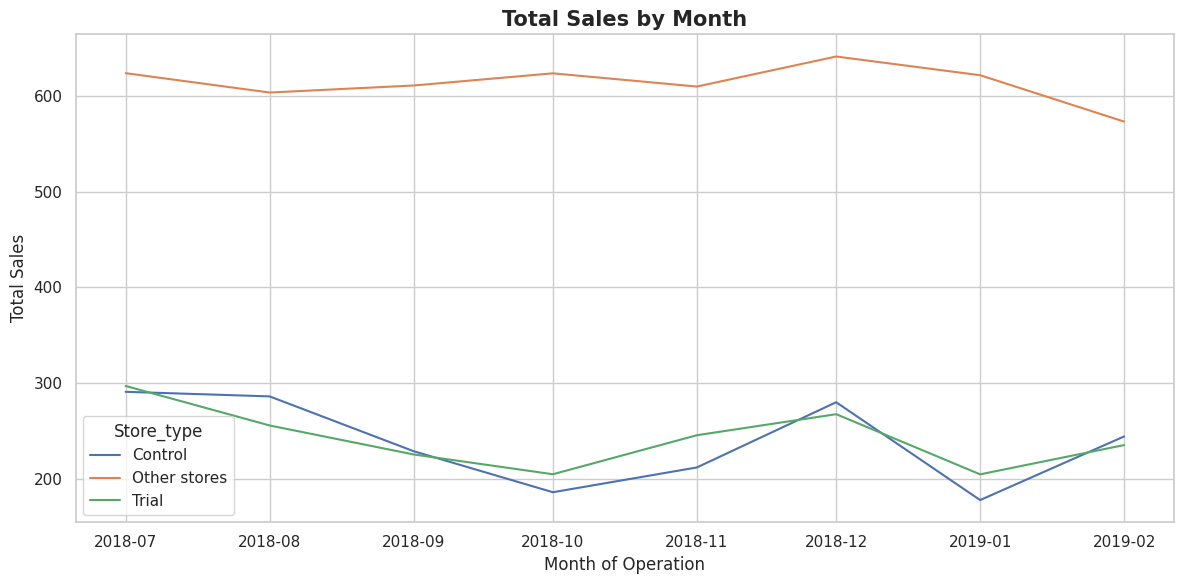

In [ ]:
# Visual check
measure_over_time_sales = measure_over_time.copy()
measure_over_time_sales['Store_type'] = measure_over_time_sales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)
past_sales = measure_over_time_sales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str), format='%Y%m') + pd.offsets.MonthBegin(0)
past_sales = past_sales[past_sales['YEARMONTH'] < 201903]

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=past_sales, x='TransactionMonth', y='totSales', hue='Store_type')
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

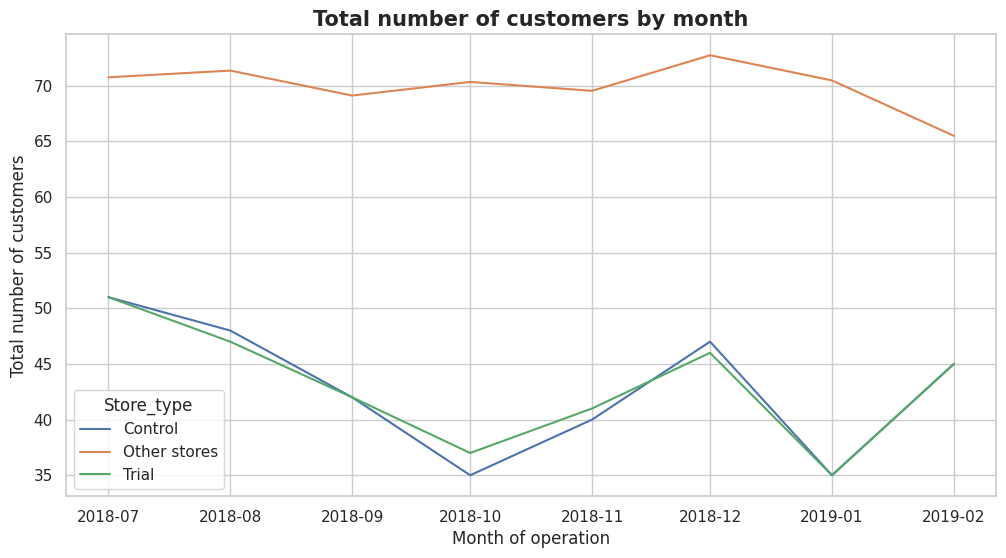

In [ ]:
# Visual checks on trends based on the drivers (Customers)

measureOverTimeCusts = measure_over_time.copy()
measureOverTimeCusts['Store_type'] = measureOverTimeCusts['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)

pastCustomers = (
    measureOverTimeCusts[measureOverTimeCusts['YEARMONTH'] < 201903]
    .groupby(['YEARMONTH', 'Store_type'], as_index=False)['nCustomers'].mean()
)
pastCustomers['TransactionMonth'] = pd.to_datetime(
    pastCustomers['YEARMONTH'].astype(str), format='%Y%m'
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=pastCustomers, x='TransactionMonth', y='nCustomers', hue='Store_type')
plt.title('Total number of customers by month')
plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')
plt.show()

### Assessment of trial
The trial period goes from the start of March 2019 to June 2019. We now want to see if there has been an
uplift in overall chip sales.
We’ll start with scaling the control store’s sales to a level similar to control for any differences between the
two stores outside of the trial period.

In [ ]:
# Assessment of trial (Scaling sales and calculating percentage difference)
scalingFactorForControlSales = (
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store)]['totSales'].sum() /
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store)]['totSales'].sum()
)

scaledControlSales = (
    measure_over_time_sales[measure_over_time_sales['STORE_NBR'] == control_store].copy()
)
scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorForControlSales

Now that we have comparable sales figures for the control store, we can calculate the percentage difference
between the scaled control sales and the trial store’s sales during the trial period.

In [ ]:
# Percentage difference in trial period
trialSales = measure_over_time[measure_over_time['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']]
percentageDiff = pd.merge(
    scaledControlSales[['YEARMONTH', 'controlSales']],
    trialSales, on='YEARMONTH'
)
percentageDiff['percentageDiff'] = np.abs(percentageDiff['controlSales'] - percentageDiff['totSales']) / percentageDiff['controlSales']


Let’s see if the difference is significant!

In [ ]:
# t-value calculation
pre_trial_diff = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff']
stdDev = pre_trial_diff.std()
degreesOfFreedom = len(pre_trial_diff) - 1

# t-values for trial months
t_critical = t.ppf(0.95, df=degreesOfFreedom)
percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff['TransactionMonth'] = pd.to_datetime(percentageDiff['YEARMONTH'].astype(str), format='%Y%m')
percentageDiff['significant'] = percentageDiff['tValue'].abs() > t_critical # Changed 't_value' to 'tValue'
t_values = percentageDiff[(percentageDiff['YEARMONTH'] > 201901) & (percentageDiff['YEARMONTH'] < 201905)][['TransactionMonth', 'tValue','significant']] # Changed 'Significance' to 'significant'
print(t_values)

  TransactionMonth     tValue  significant
7       2019-02-01   1.183534        False
8       2019-03-01   7.339116         True
9       2019-04-01  12.476373         True


We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March
and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the
control store.
Let’s create a more visual version of this by plotting the sales of the control store, the sales of the trial stores
and the 95th percentile value of sales of the control store.

In [ ]:
# Visualizing sales and confidence intervals
pastSales = measure_over_time_sales.copy()
pastSales['Store_type'] = pastSales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)
pastSales = pastSales.groupby(['YEARMONTH', 'Store_type'], as_index=False)['totSales'].mean()
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str), format='%Y%m')

In [ ]:
# Adding 95th and 5th confidence intervals for control store
control_sales = pastSales[pastSales['Store_type'] == 'Control'].copy()
control_95 = control_sales.copy()
control_95['totSales'] = control_95['totSales'] * (1 + 2 * stdDev)
control_95['Store_type'] = 'Control 95th % confidence interval'

control_5 = control_sales.copy()
control_5['totSales'] = control_5['totSales'] * (1 - 2 * stdDev)
control_5['Store_type'] = 'Control 5th % confidence interval'

trialAssessment = pd.concat([pastSales[pastSales['Store_type'].isin(['Trial', 'Control'])], control_95, control_5])

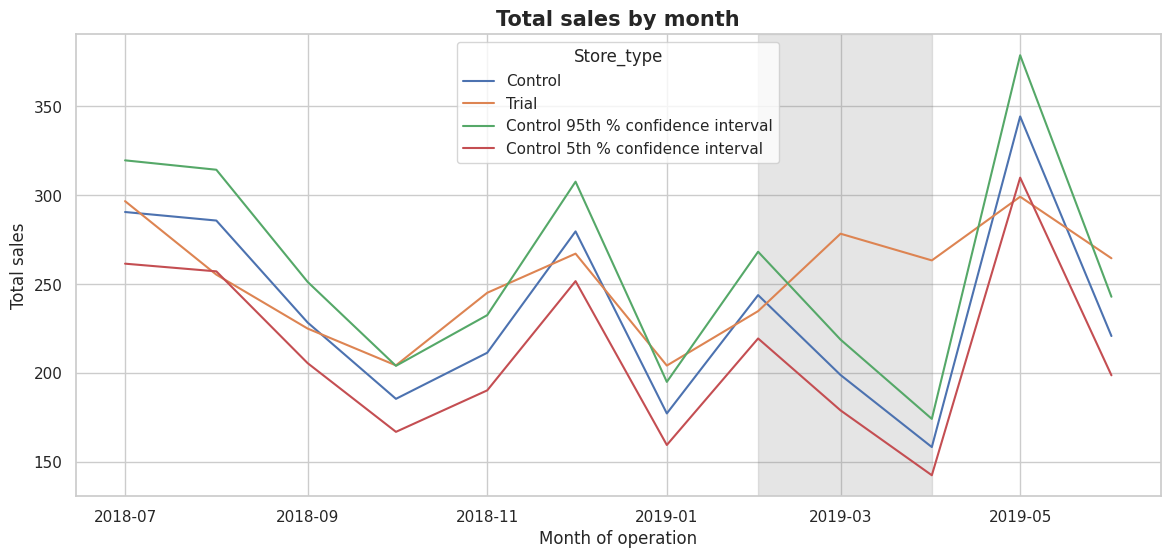

In [ ]:
# Plotting the results
plt.figure(figsize=(14, 6))
highlight = trialAssessment[(trialAssessment['YEARMONTH'] > 201901) & (trialAssessment['YEARMONTH'] < 201905)]
plt.axvspan(highlight['TransactionMonth'].min(), highlight['TransactionMonth'].max(), color='grey', alpha=0.2)
sns.lineplot(data=trialAssessment, x='TransactionMonth', y='totSales', hue='Store_type')
plt.title('Total sales by month')
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.show()

The results show that the trial in store 77 is significantly different to its control store in the trial period as
the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the
three trial months.
Let’s have a look at assessing this for number of customers as well.

In [ ]:
# Assessing number of customers
scalingFactorForControlCust = (
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store)]['nCustomers'].sum() /
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store)]['nCustomers'].sum()
)

scaledControlCustomers = measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == control_store].copy()
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorForControlCust

percentageDiffCust = pd.merge(
    scaledControlCustomers[['YEARMONTH', 'controlCustomers']],
    measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == trial_store][['YEARMONTH', 'nCustomers']],
    on='YEARMONTH'
)
percentageDiffCust['percentageDiff'] = np.abs(percentageDiffCust['controlCustomers'] - percentageDiffCust['nCustomers']) / percentageDiffCust['controlCustomers']


In [ ]:
# Standard deviation and intervals
stdDevCust = percentageDiffCust[percentageDiffCust['YEARMONTH'] < 201902]['percentageDiff'].std()

pastCustomers = measureOverTimeCusts.copy()
pastCustomers['Store_type'] = pastCustomers['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)
pastCustomers = pastCustomers.groupby(['YEARMONTH', 'Store_type'], as_index=False)['nCustomers'].mean()
pastCustomers['nCusts'] = pastCustomers['nCustomers']
pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['YEARMONTH'].astype(str), format='%Y%m')
pastCustomers = pastCustomers[pastCustomers['Store_type'].isin(['Trial', 'Control'])]

control_95_cust = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
control_95_cust['nCusts'] = control_95_cust['nCusts'] * (1 + 2 * stdDevCust)
control_95_cust['Store_type'] = 'Control 95th % confidence interval'

control_5_cust = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
control_5_cust['nCusts'] = control_5_cust['nCusts'] * (1 - 2 * stdDevCust)
control_5_cust['Store_type'] = 'Control 5th % confidence interval'

trialAssessmentCust = pd.concat([pastCustomers, control_95_cust, control_5_cust])


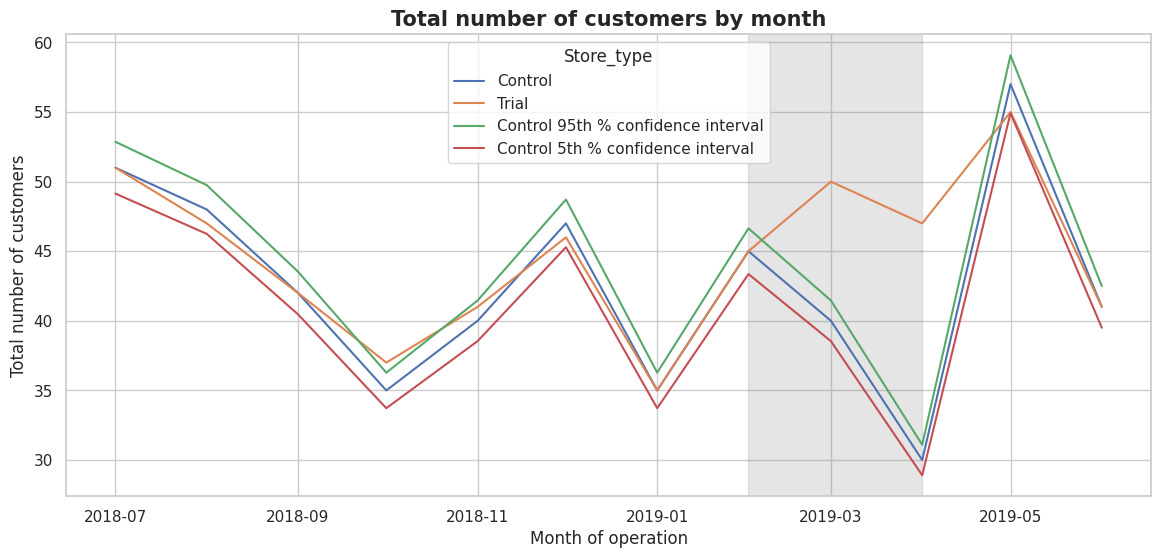

In [ ]:
# plot the results
plt.figure(figsize=(14, 6))
highlight = trialAssessmentCust[(trialAssessmentCust['YEARMONTH'] > 201901) & (trialAssessmentCust['YEARMONTH'] < 201905)]
plt.axvspan(highlight['TransactionMonth'].min(), highlight['TransactionMonth'].max(), color='grey', alpha=0.2)
sns.lineplot(data=trialAssessmentCust, x='TransactionMonth', y='nCusts', hue='Store_type')
plt.title('Total number of customers by month')
plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')
plt.show()

Let’s repeat finding the control store and assessing the impact of the trial for each of the other two trial
stores.

## Store 86

In [ ]:
# Define the measure calculations for store 86
measure_over_time = (
    data.groupby(['STORE_NBR', 'YEARMONTH'])
    .agg(
        totSales=('TOT_SALES', 'sum'),
        nCustomers=('LYLTY_CARD_NBR', pd.Series.nunique),
        nTxnPerCust=('TXN_ID', 'nunique'),
        nChipsPerTxn=('PROD_QTY', 'sum'),
        avgPricePerUnit=('TOT_SALES', 'sum')
    )
    .reset_index()
    .sort_values(['STORE_NBR', 'YEARMONTH'])
)

In [ ]:
# Use the functions for calculating correlation and magnitude for trial store 86
trial_store = 86
# Correlation
corr_nSales = calculate_correlation(pre_trial_measures, 'totSales', trial_store)
corr_nCustomers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store)
# Magnitude
mag_nSales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store)
mag_nCustomers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store)


In [ ]:
# Combine scores for correlation and magnitude
corr_weight = 0.5
score_nSales = pd.merge(corr_nSales, mag_nSales, on=['Store1', 'Store2'])
score_nSales['scoreNSales'] = score_nSales['corr_measure'] * corr_weight + \
                               score_nSales['mag_measure'] * (1 - corr_weight)

score_nCustomers = pd.merge(corr_nCustomers, mag_nCustomers, on=['Store1', 'Store2'])
score_nCustomers['scoreNCust'] = score_nCustomers['corr_measure'] * corr_weight + \
                                 score_nCustomers['mag_measure'] * (1 - corr_weight)

# Final control score
score_control = pd.merge(score_nSales, score_nCustomers, on=['Store1', 'Store2'])
score_control['finalControlScore'] = score_control['scoreNSales'] * 0.5 + score_control['scoreNCust'] * 0.5


In [ ]:
# Select control store for trial store 86
control_store = score_control[score_control['Store1'] == trial_store].sort_values('finalControlScore', ascending=False).iloc[1]['Store2']
print(f"Selected control store for trial store {trial_store}: {int(control_store)}")

Selected control store for trial store 86: 155


Looks like store 155 will be a control store for trial store 86. Again, let’s check visually if the drivers are
indeed similar in the period before the trial.
We’ll look at total sales first.

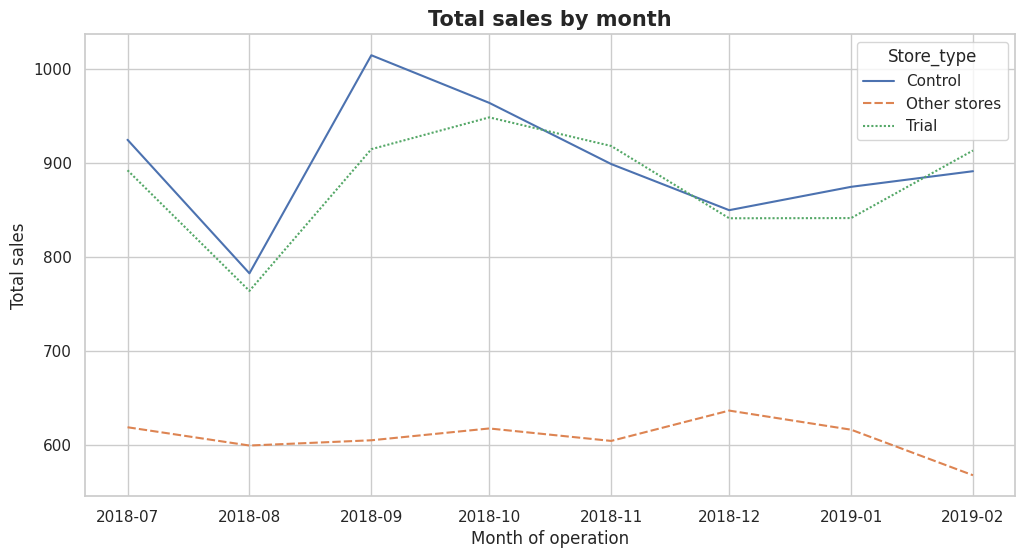

In [ ]:
# Visual checks on trends based on the drivers (Total Sales)
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)

measure_over_time['TransactionMonth'] = pd.to_datetime(
    measure_over_time['YEARMONTH'].astype(str), format='%Y%m'
)

# Sales
past_sales = (
    measure_over_time.groupby(['YEARMONTH', 'Store_type'])
    .agg(totSales=('totSales', 'mean'))
    .reset_index()
)
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str), format='%Y%m')
past_sales = past_sales[past_sales['YEARMONTH'] < 201903]

plt.figure(figsize=(12, 6))
sns.lineplot(data=past_sales, x='TransactionMonth', y='totSales', hue='Store_type', style='Store_type')
plt.title('Total sales by month')
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.show()

Great, sales are trending in a similar way.
Next, number of customers.

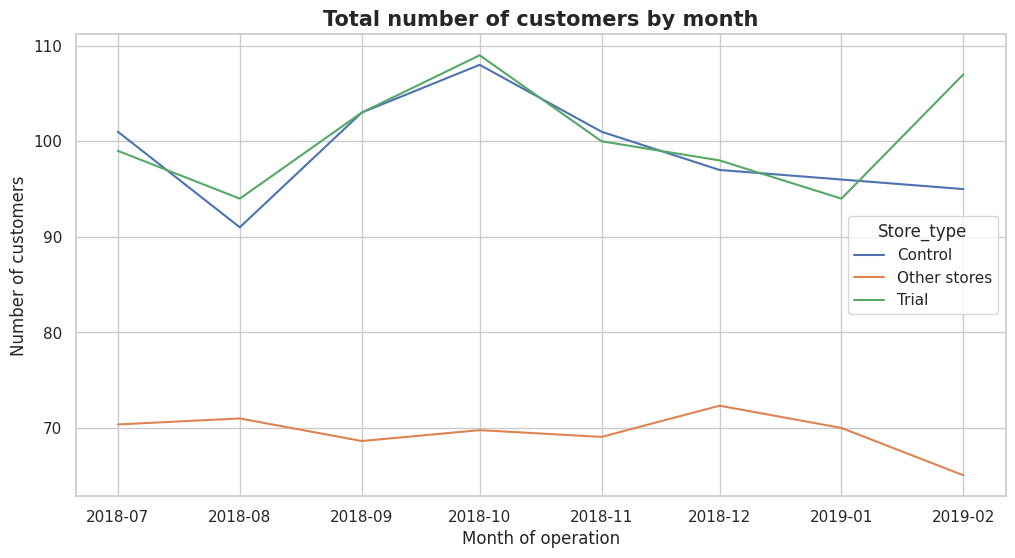

In [ ]:
# Customers
past_customers = (
    measure_over_time.groupby(['YEARMONTH', 'Store_type'])
    .agg(numberCustomers=('nCustomers', 'mean'))
    .reset_index()
)
past_customers['TransactionMonth'] = pd.to_datetime(past_customers['YEARMONTH'].astype(str), format='%Y%m')
past_customers = past_customers[past_customers['YEARMONTH'] < 201903]

plt.figure(figsize=(12, 6))
sns.lineplot(data=past_customers, x='TransactionMonth', y='numberCustomers', hue='Store_type')
plt.title('Total number of customers by month')
plt.xlabel('Month of operation')
plt.ylabel('Number of customers')
plt.show()

Good, the trend in number of customers is also similar.
Let’s now assess the impact of the trial on sales.

In [ ]:
# t-value calculation
pre_trial_diff = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff']
stdDev = pre_trial_diff.std()
degreesOfFreedom = len(pre_trial_diff) - 1

# t-values for trial months
t_critical = t.ppf(0.95, df=degreesOfFreedom)
percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff['TransactionMonth'] = pd.to_datetime(percentageDiff['YEARMONTH'].astype(str), format='%Y%m')
percentageDiff['significant'] = percentageDiff['tValue'].abs() > t_critical # Changed 't_value' to 'tValue'
t_values = percentageDiff[(percentageDiff['YEARMONTH'] > 201901) & (percentageDiff['YEARMONTH'] < 201905)][['TransactionMonth', 'tValue','significant']] # Changed 'Significance' to 'significant'
print(t_values)

In [ ]:
# Assessment of the impact of the trial on sales for store 86
# Scaling factor
trial_sales = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum()
control_sales = pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < 201902)]['totSales'].sum()
scaling_factor = trial_sales / control_sales

# Apply scaling
scaled_control = measure_over_time[measure_over_time['STORE_NBR'] == control_store].copy()
scaled_control['controlSales'] = scaled_control['totSales'] * scaling_factor

# % difference
trial_sales = measure_over_time[measure_over_time['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']]
control_sales = scaled_control[['YEARMONTH', 'controlSales']]
percentage_diff = pd.merge(control_sales, trial_sales, on='YEARMONTH')
percentage_diff['percentageDiff'] = abs(percentage_diff['controlSales'] - percentage_diff['totSales']) / percentage_diff['controlSales']

# Std dev from pre-trial
std_dev = percentage_diff[percentage_diff['YEARMONTH'] < 201902]['percentageDiff'].std()
degrees_freedom = 7

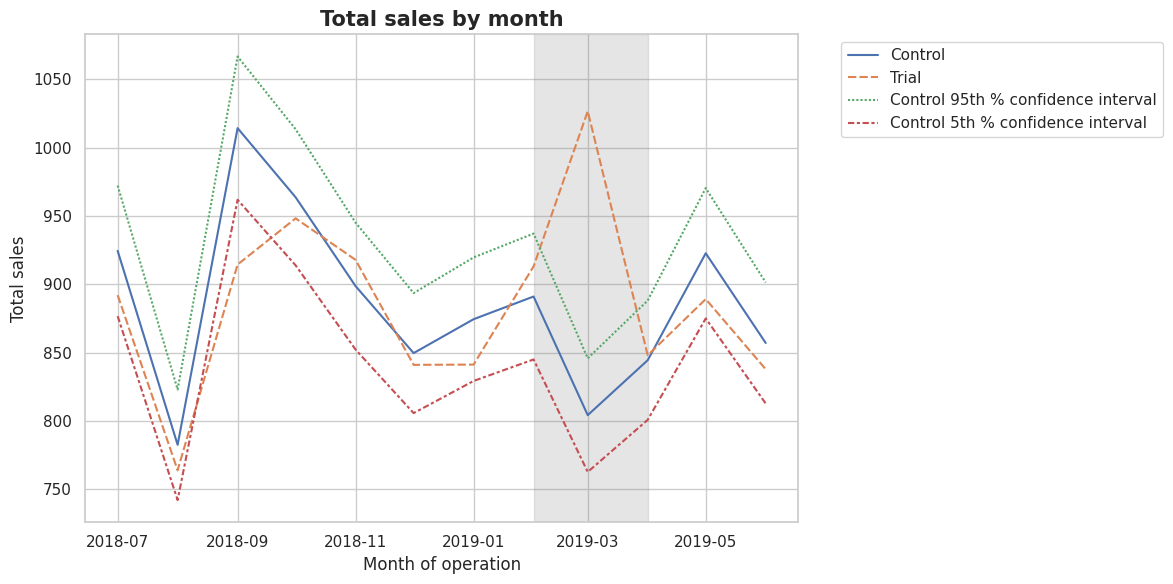

In [ ]:
# Visualizing sales and confidence intervals
# Average sales per store type
filtered = measure_over_time[measure_over_time['Store_type'].isin(['Trial', 'Control'])]
past_sales = filtered.groupby(['YEARMONTH', 'Store_type']).agg(totSales=('totSales', 'mean')).reset_index()
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str), format='%Y%m')

# Confidence intervals
upper = past_sales[past_sales['Store_type'] == 'Control'].copy()
upper['totSales'] *= (1 + std_dev * 2)
upper['Store_type'] = 'Control 95th % confidence interval'

lower = past_sales[past_sales['Store_type'] == 'Control'].copy()
lower['totSales'] *= (1 - std_dev * 2)
lower['Store_type'] = 'Control 5th % confidence interval'

# Combine
trial_assessment = pd.concat([past_sales, upper, lower])

# Plot
highlight_period = trial_assessment[(trial_assessment['YEARMONTH'] > 201901) & (trial_assessment['YEARMONTH'] < 201905)]

plt.figure(figsize=(12, 6))
plt.axvspan(highlight_period['TransactionMonth'].min(), highlight_period['TransactionMonth'].max(), color='gray', alpha=0.2)
sns.lineplot(data=trial_assessment, x='TransactionMonth', y='totSales', hue='Store_type', style='Store_type')
plt.title('Total sales by month')
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The results show that the trial in store 86 is not significantly different to its control store in the trial period
as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the
three trial months.
Let’s have a look at assessing this for number of customers as well.

In [ ]:
# Scaling pre-trial control customers to match pre-trial trial store customers
scaling_factor_cust = (
    pre_trial_measures[(pre_trial_measures["STORE_NBR"] == trial_store) & (pre_trial_measures["YEARMONTH"] < 201902)]["nCustomers"].sum() /
    pre_trial_measures[(pre_trial_measures["STORE_NBR"] == control_store) & (pre_trial_measures["YEARMONTH"] < 201902)]["nCustomers"].sum()
)

In [ ]:
# Apply the scaling factor
scaled_control_customers = measure_over_time[measure_over_time["STORE_NBR"] == control_store].copy()
scaled_control_customers["controlCustomers"] = scaled_control_customers["nCustomers"] * scaling_factor_cust
scaled_control_customers["Store_type"] = "Control"

In [ ]:
# Merge and calculate percentage difference
customer_comparison = pd.merge(
    scaled_control_customers[["YEARMONTH", "controlCustomers"]],
    trialAssessmentCust[["YEARMONTH", "nCustomers"]],
    on="YEARMONTH"
)
customer_comparison["percentageDiff"] = abs(customer_comparison["controlCustomers"] - customer_comparison["nCustomers"]) / customer_comparison["controlCustomers"]

In [ ]:
# Get standard deviation in pre-trial period
std_dev_cust = customer_comparison[customer_comparison["YEARMONTH"] < 201902]["percentageDiff"].std()
degrees_of_freedom = 7  # same as R

In [ ]:
# Monthly average customers for plotting
measure_over_time_cust = measure_over_time.copy()
measure_over_time_cust["Store_type"] = measure_over_time_cust["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else "Control" if x == control_store else "Other stores"
)

past_customers = measure_over_time_cust.groupby(["YEARMONTH", "Store_type"]).agg(nCusts=("nCustomers", "mean")).reset_index()
past_customers["TransactionMonth"] = pd.to_datetime(past_customers["YEARMONTH"].astype(str), format='%Y%m')

In [ ]:
# Calculate standard deviation of the percentage difference in the pre-trial period
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()

In [ ]:
# Add confidence intervals
customers_95 = past_customers[past_customers["Store_type"] == "Control"].copy()
customers_95["nCusts"] *= (1 + std_dev_cust * 2)
customers_95["Store_type"] = "Control 95th % confidence interval"

customers_5 = past_customers[past_customers["Store_type"] == "Control"].copy()
customers_5["nCusts"] *= (1 - std_dev_cust * 2)
customers_5["Store_type"] = "Control 5th % confidence interval"

trial_assessment_cust = pd.concat([past_customers, customers_95, customers_5])

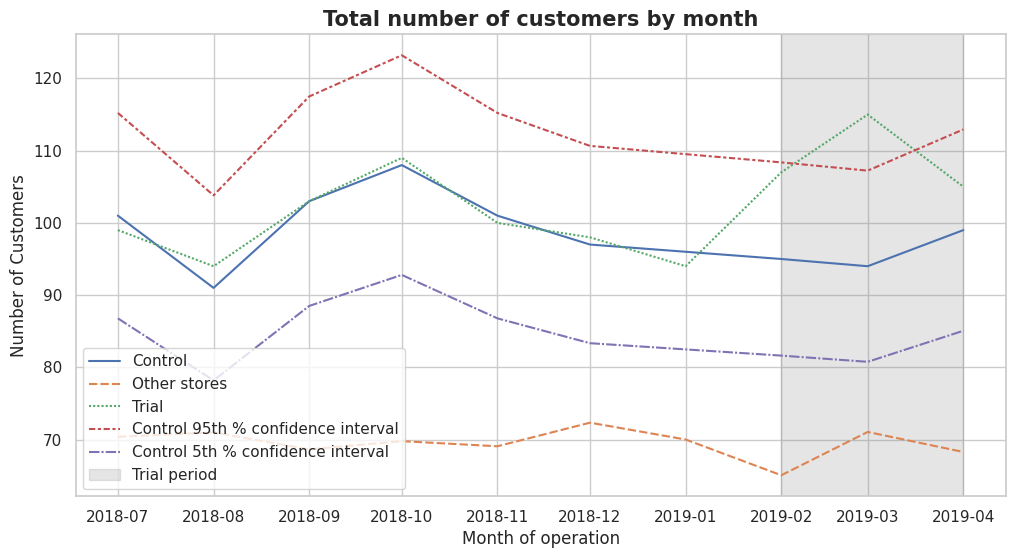

In [ ]:
# Visualizing confidence intervals and customer trends for store 86
plt.figure(figsize=(12,6))
sns.lineplot(data=trial_assessment_cust[trial_assessment_cust["YEARMONTH"] < 201905],
             x="TransactionMonth", y="nCusts", hue="Store_type", style="Store_type")

plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-01"),
            color="gray", alpha=0.2, label="Trial period")
plt.title("Total number of customers by month")
plt.xlabel("Month of operation")
plt.ylabel("Number of Customers")
plt.legend()
plt.show()

It looks like the number of customers is significantly higher in all of the three months. This seems to
suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but
as we saw, sales were not significantly higher. We should check with the Category Manager if there were
special deals in the trial store that were may have resulted in lower prices, impacting the results.

## Store 88

In [ ]:
measure_over_time = data.groupby(["STORE_NBR", "YEARMONTH"]).agg(
    totSales=("TOT_SALES", "sum"),
    nCustomers=("LYLTY_CARD_NBR", pd.Series.nunique),
    nTxnPerCust=("TXN_ID", lambda x: x.nunique() / data.loc[x.index, "LYLTY_CARD_NBR"].nunique()),
    nChipsPerTxn=("PROD_QTY", lambda x: x.sum() / data.loc[x.index, "TXN_ID"].nunique()),
    avgPricePerUnit=("TOT_SALES", lambda x: x.sum() / data.loc[x.index, "PROD_QTY"].sum())
).reset_index().sort_values(by=["STORE_NBR", "YEARMONTH"])

In [ ]:
# Using functions for calculating correlation and magnitude for trial store 88
trial_store = 88
corr_nSales = calculate_correlation(pre_trial_measures, "totSales", trial_store)
corr_nCustomers = calculate_correlation(pre_trial_measures, "nCustomers", trial_store)

magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, "totSales", trial_store)
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, "nCustomers", trial_store)

In [ ]:
# Combine scores for correlation and magnitude
corr_weight = 0.5
score_nSales = corr_nSales.merge(magnitude_nSales, on=["Store1", "Store2"])
score_nSales["scoreNSales"] = score_nSales["corr_measure"] * corr_weight + score_nSales["mag_measure"] * (1 - corr_weight)

score_nCustomers = corr_nCustomers.merge(magnitude_nCustomers, on=["Store1", "Store2"])
score_nCustomers["scoreNCust"] = score_nCustomers["corr_measure"] * corr_weight + score_nCustomers["mag_measure"] * (1 - corr_weight)

# Final combined score
score_control = score_nSales.merge(score_nCustomers, on=["Store1", "Store2"])
score_control["finalControlScore"] = score_control["scoreNSales"] * 0.5 + score_control["scoreNCust"] * 0.5

In [ ]:
# Select control store for trial store 88
control_store = score_control[score_control["Store1"] == trial_store].sort_values(by="finalControlScore", ascending=False).iloc[1]["Store2"]
print("Control store for trial store 88:", int(control_store))

Control store for trial store 88: 237


We’ve now found store 237 to be a suitable control store for trial store 88.
Again, let’s check visually if the drivers are indeed similar in the period before the trial.
We’ll look at total sales first.

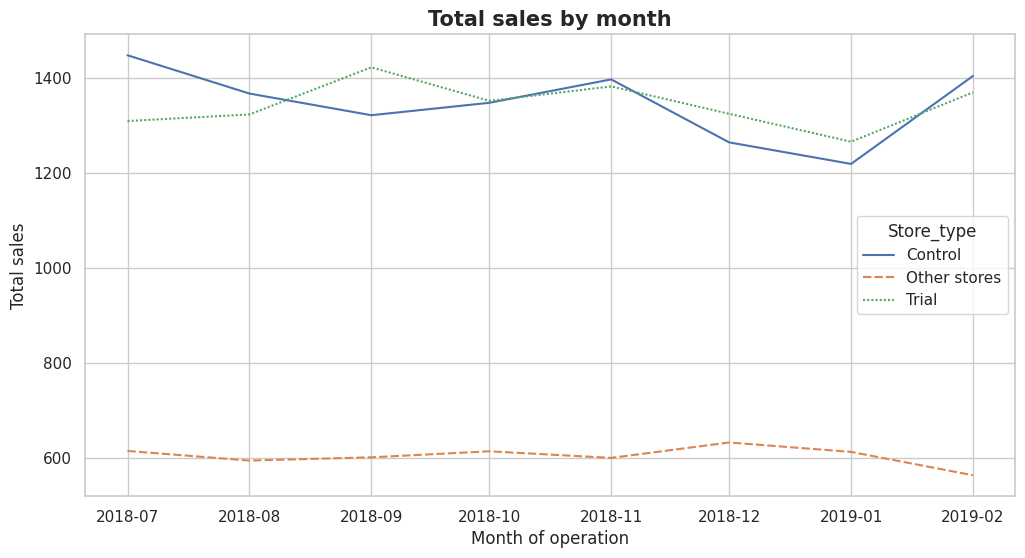

In [ ]:
# Visual checks on trends based on the drivers (Total Sales)
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store else 'Other stores'
)

measure_over_time['TransactionMonth'] = pd.to_datetime(
    measure_over_time['YEARMONTH'].astype(str), format='%Y%m'
)

# Sales
past_sales = (
    measure_over_time.groupby(['YEARMONTH', 'Store_type'])
    .agg(totSales=('totSales', 'mean'))
    .reset_index()
)
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'].astype(str), format='%Y%m')
past_sales = past_sales[past_sales['YEARMONTH'] < 201903]

plt.figure(figsize=(12, 6))
sns.lineplot(data=past_sales, x='TransactionMonth', y='totSales', hue='Store_type', style='Store_type')
plt.title('Total sales by month')
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.show()

Great, the trial and control stores have similar total sales.
Next, number of customers.

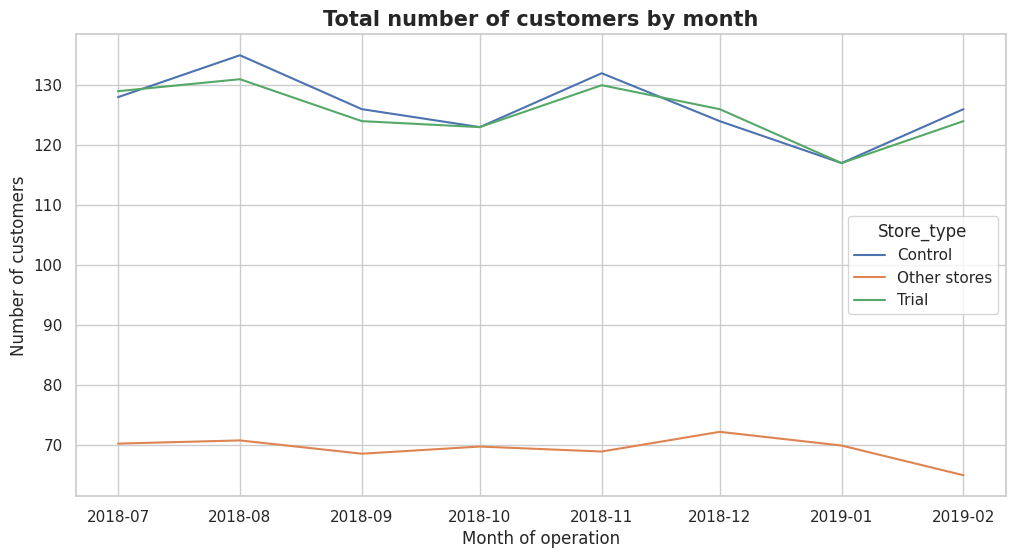

In [ ]:
# Customers
past_customers = (
    measure_over_time.groupby(['YEARMONTH', 'Store_type'])
    .agg(numberCustomers=('nCustomers', 'mean'))
    .reset_index()
)
past_customers['TransactionMonth'] = pd.to_datetime(past_customers['YEARMONTH'].astype(str), format='%Y%m')
past_customers = past_customers[past_customers['YEARMONTH'] < 201903]

plt.figure(figsize=(12, 6))
sns.lineplot(data=past_customers, x='TransactionMonth', y='numberCustomers', hue='Store_type')
plt.title('Total number of customers by month')
plt.xlabel('Month of operation')
plt.ylabel('Number of customers')
plt.show()

Total number of customers of the control and trial stores are also similar.
Let’s now assess the impact of the trial on sales.

In [ ]:
# t-value calculation
pre_trial_diff = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff']
stdDev = pre_trial_diff.std()
degreesOfFreedom = len(pre_trial_diff) - 1

# t-values for trial months
t_critical = t.ppf(0.95, df=degreesOfFreedom)
percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff['TransactionMonth'] = pd.to_datetime(percentageDiff['YEARMONTH'].astype(str), format='%Y%m')
percentageDiff['significant'] = percentageDiff['tValue'].abs() > t_critical # Changed 't_value' to 'tValue'
t_values = percentageDiff[(percentageDiff['YEARMONTH'] > 201901) & (percentageDiff['YEARMONTH'] < 201905)][['TransactionMonth', 'tValue','significant']] # Changed 'Significance' to 'significant'
print(t_values)

In [ ]:
# Scale pre-trial sales for control
scaling_factor_sales = (
    pre_trial_measures[(pre_trial_measures["STORE_NBR"] == trial_store) & (pre_trial_measures["YEARMONTH"] < 201902)]["totSales"].sum() /
    pre_trial_measures[(pre_trial_measures["STORE_NBR"] == control_store) & (pre_trial_measures["YEARMONTH"] < 201902)]["totSales"].sum()
)

# Apply scaling
measure_over_time_sales = measure_over_time.copy()
scaled_control_sales = measure_over_time_sales[measure_over_time_sales["STORE_NBR"] == control_store].copy()
scaled_control_sales["controlSales"] = scaled_control_sales["totSales"] * scaling_factor_sales

# Calculate percentage difference
trial_sales = measure_over_time_sales[measure_over_time_sales["STORE_NBR"] == trial_store][["YEARMONTH", "totSales"]].copy()

percentage_diff_sales = pd.merge(
    scaled_control_sales[["YEARMONTH", "controlSales"]],
    trial_sales,
    on="YEARMONTH"
)
percentage_diff_sales["percentageDiff"] = abs(percentage_diff_sales["controlSales"] - percentage_diff_sales["totSales"]) / percentage_diff_sales["controlSales"]


In [ ]:
# Std dev in pre-trial
std_dev_sales = percentage_diff_sales[percentage_diff_sales["YEARMONTH"] < 201902]["percentageDiff"].std()
degrees_of_freedom = 7

In [ ]:
measure_over_time_sales["Store_type"] = measure_over_time_sales["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else "Control" if x == control_store else "Other stores"
)

past_sales = measure_over_time_sales.groupby(["YEARMONTH", "Store_type"]).agg(
    totSales=("totSales", "mean")
).reset_index()
past_sales["TransactionMonth"] = pd.to_datetime(past_sales["YEARMONTH"].astype(str), format="%Y%m")

# Confidence intervals
past_sales_95 = past_sales[past_sales["Store_type"] == "Control"].copy()
past_sales_95["totSales"] *= (1 + std_dev_sales * 2)
past_sales_95["Store_type"] = "Control 95th % confidence interval"

past_sales_5 = past_sales[past_sales["Store_type"] == "Control"].copy()
past_sales_5["totSales"] *= (1 - std_dev_sales * 2)
past_sales_5["Store_type"] = "Control 5th % confidence interval"

trial_assessment_sales = pd.concat([past_sales, past_sales_95, past_sales_5])


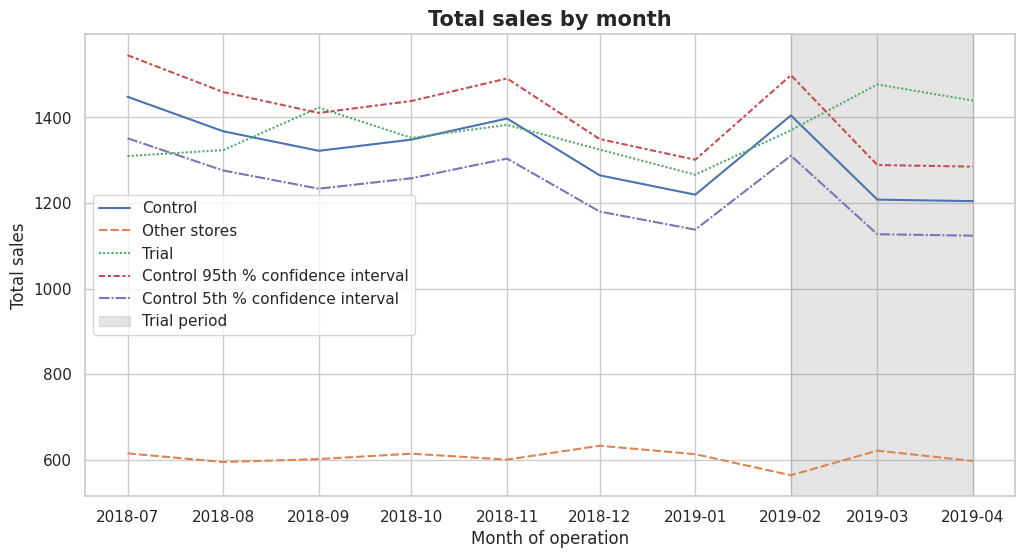

In [ ]:
# Visual checks on trends based on the drivers for total sales and number of customers
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment_sales[trial_assessment_sales["YEARMONTH"] < 201905],
             x="TransactionMonth", y="totSales", hue="Store_type", style="Store_type")

plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-01"),
            color="gray", alpha=0.2, label="Trial period")
plt.title("Total sales by month")
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.legend()
plt.show()

The results show that the trial in store 88 is significantly different to its control store in the trial period as the
trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the
three trial months.
Let’s have a look at assessing this for number of customers as well.

In [ ]:
# Scale pre-trial control sales to match pre-trial trial store sales
scaling_factor_customers = (
    pre_trial_measures[(pre_trial_measures["STORE_NBR"] == trial_store) & (pre_trial_measures["YEARMONTH"] < 201902)]["nCustomers"].sum() /
    pre_trial_measures[(pre_trial_measures["STORE_NBR"] == control_store) & (pre_trial_measures["YEARMONTH"] < 201902)]["nCustomers"].sum()
)

measure_over_time_cust = measure_over_time.copy()
scaled_control_customers = measure_over_time_cust[measure_over_time_cust["STORE_NBR"] == control_store].copy()
scaled_control_customers["controlCustomers"] = scaled_control_customers["nCustomers"] * scaling_factor_customers

scaled_control_customers["Store_type"] = scaled_control_customers["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else "Control" if x == control_store else "Other stores"
)

trial_customers = measure_over_time_cust[measure_over_time_cust["STORE_NBR"] == trial_store][["YEARMONTH", "nCustomers"]].copy()

percentage_diff_customers = pd.merge(
    scaled_control_customers[["YEARMONTH", "controlCustomers"]],
    trial_customers,
    on="YEARMONTH"
)
percentage_diff_customers["percentageDiff"] = abs(percentage_diff_customers["controlCustomers"] - percentage_diff_customers["nCustomers"]) / percentage_diff_customers["controlCustomers"]

std_dev_customers = percentage_diff_customers[percentage_diff_customers["YEARMONTH"] < 201902]["percentageDiff"].std()

In [ ]:
# Create Trial vs Control Customer Plot Data
measure_over_time_cust["Store_type"] = measure_over_time_cust["STORE_NBR"].apply(
    lambda x: "Trial" if x == trial_store else "Control" if x == control_store else "Other stores"
)

past_customers = measure_over_time_cust.groupby(["YEARMONTH", "Store_type"]).agg(
    nCusts=("nCustomers", "mean")
).reset_index()
past_customers["TransactionMonth"] = pd.to_datetime(past_customers["YEARMONTH"].astype(str), format="%Y%m")

past_cust_95 = past_customers[past_customers["Store_type"] == "Control"].copy()
past_cust_95["nCusts"] *= (1 + std_dev_customers * 2)
past_cust_95["Store_type"] = "Control 95th % confidence interval"

past_cust_5 = past_customers[past_customers["Store_type"] == "Control"].copy()
past_cust_5["nCusts"] *= (1 - std_dev_customers * 2)
past_cust_5["Store_type"] = "Control 5th % confidence interval"

trial_assessment_customers = pd.concat([past_customers, past_cust_95, past_cust_5])

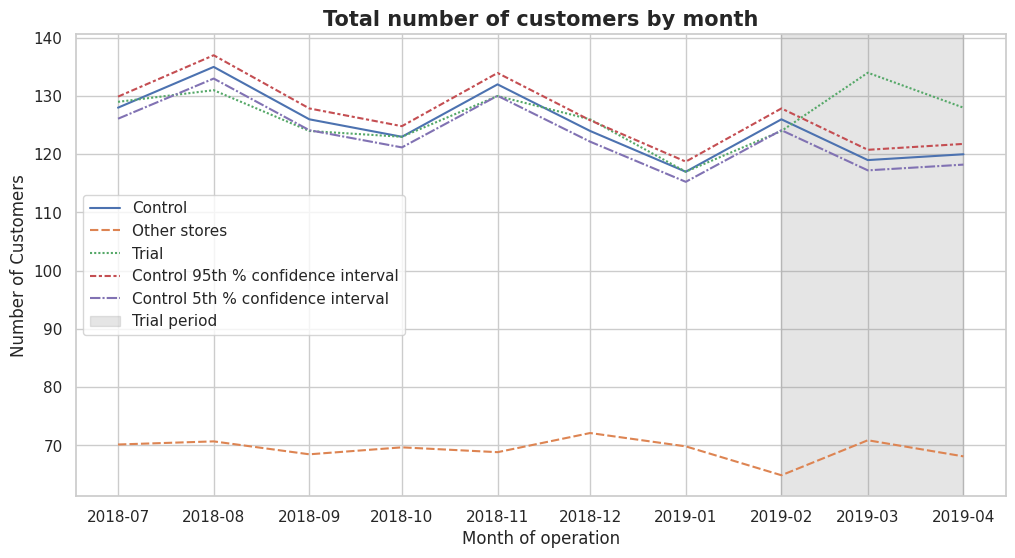

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=trial_assessment_customers[trial_assessment_customers["YEARMONTH"] < 201905],
             x="TransactionMonth", y="nCusts", hue="Store_type", style="Store_type")

plt.axvspan(pd.to_datetime("2019-02-01"), pd.to_datetime("2019-04-01"),
            color="gray", alpha=0.2, label="Trial period")
plt.title("Total number of customers by month")
plt.xlabel("Month of operation")
plt.ylabel("Number of Customers")
plt.legend()
plt.show()


Total number of customers of the control and trial stores are also similar.
Let’s now assess the impact of the trial on sales.

# Conclusion
We’ve found control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.
- The results for trial stores 77 and 88 during the trial period show a significant difference in at least two of the
three trial months but this is not the case for trial store 86.
- We can check with the client if the implementation
of the trial was different in trial store 86 but overall, the trial shows a significant increase in sales. Now that
we have finished our analysis, we can prepare our presentation to the Category Manager